# Titanic ML

This will be a simple machine learning project to predict the survival of passengers on the Titanic. The data is from the Kaggle competition [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic).



In [75]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model

import os
for dirname, _, filenames in os.walk('titanic'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


titanic\gender_submission.csv
titanic\test.csv
titanic\train.csv


### Read Data

In [76]:
titanic_df = pd.read_csv("titanic/train.csv")
test_df = pd.read_csv('titanic/test.csv')
gender_df = pd.read_csv('titanic/gender_submission.csv')

### Data Information

In [77]:
titanic_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [78]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Here, we can see that Age and Cabin have missing values. We will need to deal with these later.

In [79]:
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

There is also a lot of missing data in the Cabin column. 

<AxesSubplot:>

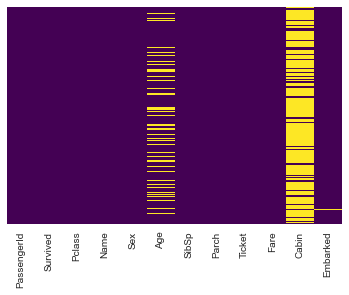

In [80]:
sns.heatmap(titanic_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

PassengerId, Name, Ticket should not affect the survival rate, so we can drop them. We will also drop Cabin because it has too many missing values.

In [81]:
titanic_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'],
                axis=1,
                inplace=True)

test_df.drop(['Name', 'Ticket', 'Cabin'],
                axis=1,
                inplace=True)


For missing values in Age, we can fill them with the mean age. For Embarked, we can fill them with the most common value.

To be more accurate, we will fill missing values in the "Age" column with the mean age of the passengers in the same class and of the same gender.

In [82]:
titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode()[0], inplace=True)

titanic_df['Age'] = titanic_df.groupby(
    ['Sex', 'Pclass'])['Age'].apply(lambda row: row.fillna(row.mean()))

## We also need to do the same to the test df
test_df['Embarked'].fillna(titanic_df['Embarked'].mode()[0], inplace=True)

test_df['Age'] = titanic_df.groupby(
    ['Sex', 'Pclass'])['Age'].apply(lambda row: row.fillna(row.mean()))

titanic_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.00,1,0,7.2500,S
1,1,1,female,38.00,1,0,71.2833,C
2,1,3,female,26.00,0,0,7.9250,S
3,1,1,female,35.00,1,0,53.1000,S
4,0,3,male,35.00,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.00,0,0,13.0000,S
887,1,1,female,19.00,0,0,30.0000,S
888,0,3,female,21.75,1,2,23.4500,S
889,1,1,male,26.00,0,0,30.0000,C


Our final dataset looks like this:

In [83]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [84]:
print('Total Male Passengers: ', titanic_df['Sex'].value_counts()['male'])
print('Total Female Passengers: ', titanic_df['Sex'].value_counts()['female'])

Total Male Passengers:  577
Total Female Passengers:  314


## Part Two: Data Visualization

Visualization is a great way to get a feel for the data. We can use seaborn and matplotlib to create some plots.

C:\Users\aaaab\AppData\Local\Temp\ipykernel_1604\604696925.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


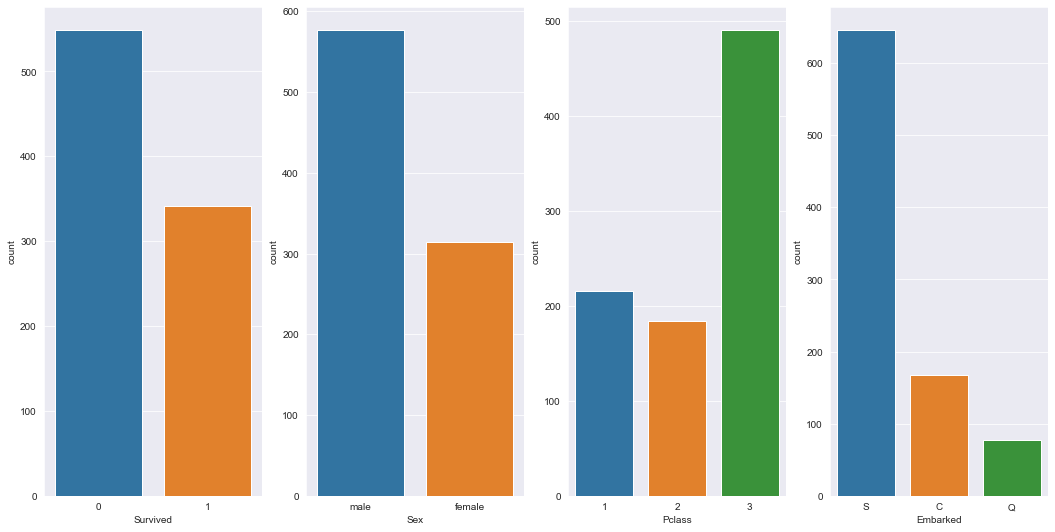

In [85]:
fig, ax = plt.subplots(1, 4, figsize=(18, 9))
sns.countplot(x='Survived', data=titanic_df, ax=ax[0])
sns.countplot(x='Sex', data=titanic_df, ax=ax[1])
sns.countplot(x='Pclass', data=titanic_df, ax=ax[2])
sns.countplot(x='Embarked', data=titanic_df, ax=ax[3])
fig.show()

Here we can gain some insite on the data:
 - Most of the passengers did not survive
 - Most of the passengers were male
 - Most of the passengers were in class 3
 - Most of them embarked from Southampton

<AxesSubplot:xlabel='Survived', ylabel='count'>

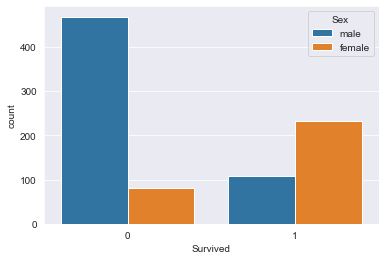

In [86]:
sns.set_style('darkgrid')
sns.countplot(x='Survived', hue='Sex', data=titanic_df)

Most of the passengers who survived were female.

<AxesSubplot:xlabel='Survived', ylabel='count'>

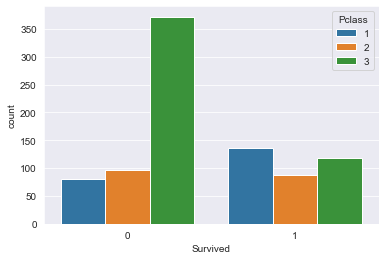

In [87]:
sns.set_style('darkgrid')
sns.countplot(x='Survived', hue='Pclass', data=titanic_df)

Most of the passengers who survived were in class 1.

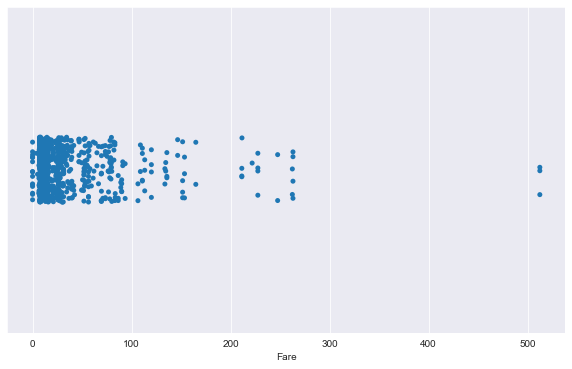

In [88]:
plt.figure(figsize=(10, 6))
sns.stripplot(x='Fare', data=titanic_df)
plt.show()

The most common fare prices were between 0 and 50.

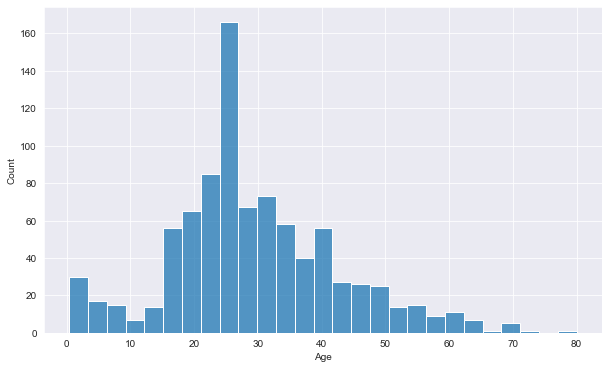

In [89]:
plt.figure(figsize=(10, 6))
sns.histplot(x='Age', data=titanic_df)
plt.show()

The most common age was between 20 and 30.

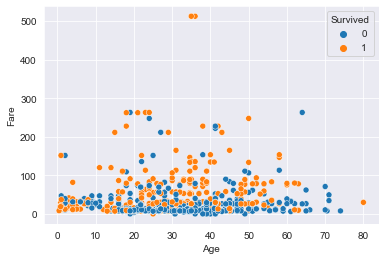

In [90]:
plt.Figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=titanic_df)
plt.show()

There doesn't seem to be an obvious correlation between age and fare. What about Age and PClass?

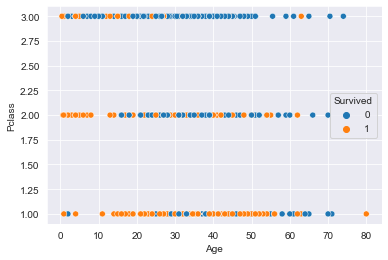

In [91]:
plt.Figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Pclass', hue='Survived', data=titanic_df)
plt.show()

Here it is interesting, seems like the older the passenger, the higher the class. And older passengers with higher class tend to have higher survival rate.

Simple Correlation Heatmap:

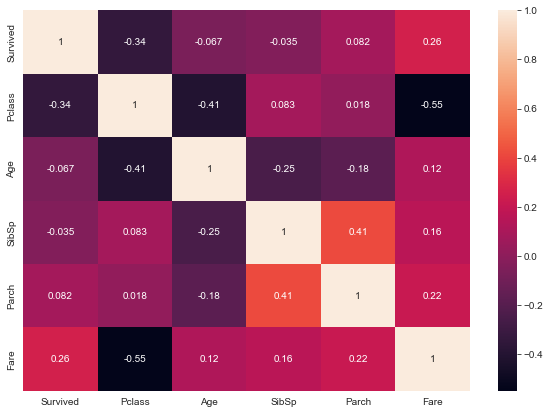

In [92]:
plt.figure(figsize=(10, 7))
sns.heatmap(titanic_df.corr(), annot=True)
plt.show()

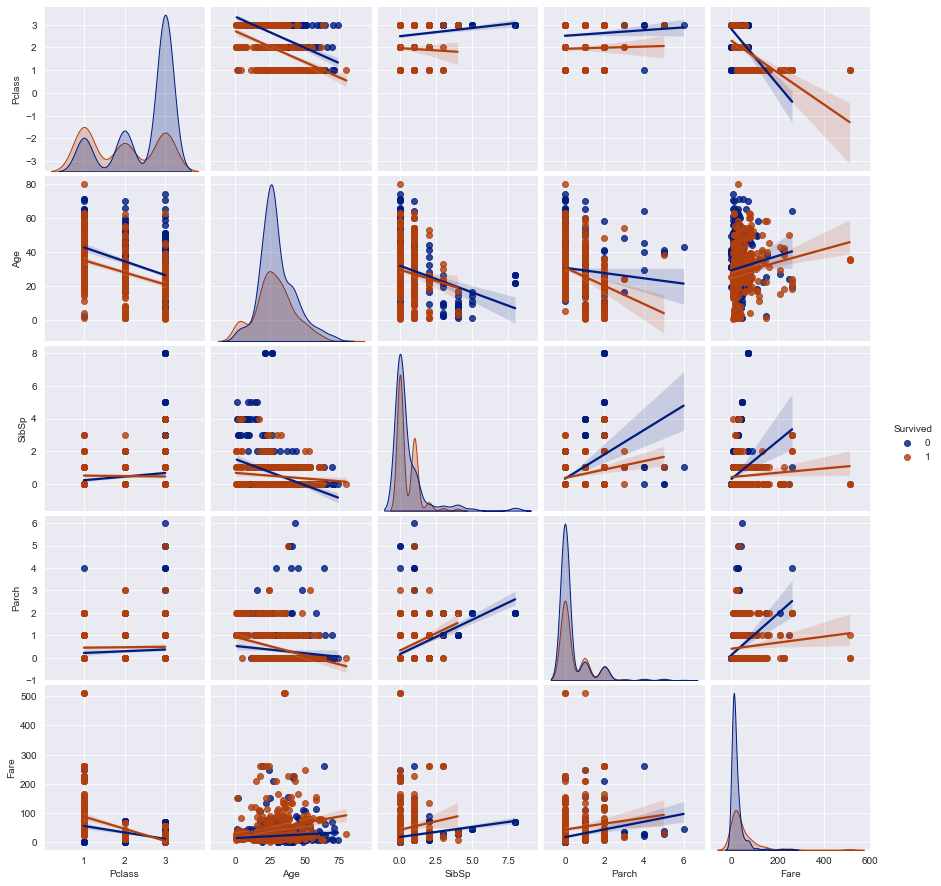

In [93]:
sns.pairplot(data=titanic_df,
             hue="Survived",
             diag_kind="kde",
             kind="reg",
             palette="dark",
             corner=False,
             dropna=True,
             height=2.5,
             aspect=1)
plt.show()

## Part Three: Data Cleaning

Now that we've visualized the data, we can start to clean it up. 

In [94]:
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Our data here is categorical, so we need to convert them to numerical values. We will use OneHotEncoder to do that.

In [95]:
titanic_df = pd.get_dummies(titanic_df, columns=['Pclass', 'Sex', 'Embarked'])
test_df = pd.get_dummies(test_df, columns=['Pclass', 'Sex', 'Embarked'])

titanic_df.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
4,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


Next, we will normalize the data. This is not necessary for all machine learning algorithms, but it is a good practice.
We will also take care to note mean and standard deviation of the training data.

In [96]:
ageMean = titanic_df['Age'].mean()
ageStd = titanic_df['Age'].std()

print('Mean Age: ', ageMean)
print('Standard Deviation of Age: ', ageStd)

fareMean = titanic_df['Fare'].mean()
fareStd = titanic_df['Fare'].std()

print('Mean Fare: ', fareMean)
print('Standard Deviation of Fare: ', fareStd)

titanic_df['Fare'] = (titanic_df['Fare'] -
                      fareMean) / fareStd
titanic_df['Age'] = (titanic_df['Age'] -
                     ageMean) / ageStd

titanic_df.head()


Mean Age:  29.318642716644145
Standard Deviation of Age:  13.281102760334132
Mean Fare:  32.204207968574636
Standard Deviation of Fare:  49.6934285971809


,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,-0.551057,1,0,-0.502163,0,0,1,0,1,0,0,1
1,1,0.653662,1,0,0.786404,1,0,0,1,0,1,0,0
2,1,-0.249877,0,0,-0.488580,0,0,1,1,0,0,0,1
3,1,0.427778,1,0,0.420494,1,0,0,1,0,0,0,1
4,0,0.427778,0,0,-0.486064,0,0,1,0,1,0,0,1


Our data is now ready to be fed into a machine learning algorithm. But first lets check the test data.

In [97]:
test_df.describe()

,PassengerId,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
count,418.000000,418.000000,418.000000,418.000000,417.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,28.432822,0.447368,0.392344,35.627188,0.255981,0.222488,0.521531,0.363636,0.636364,0.244019,0.110048,0.645933
std,120.810458,12.950068,0.896760,0.981429,55.907576,0.436934,0.416416,0.500135,0.481622,0.481622,0.430019,0.313324,0.478803
min,892.000000,0.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,996.250000,21.750000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1100.500000,26.507589,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1204.750000,35.000000,1.000000,0.000000,31.500000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1309.000000,71.000000,8.000000,9.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Looks like we are missing some values in the Fare column. We will fill them with the mean fare. We also need to normalize the data.

In [98]:
test_df['Fare'].fillna(test_df['Fare'].mean(), inplace=True)
test_df['Fare'] = (test_df['Fare'] - test_df['Fare'].mean()) / test_df['Fare'].std()
test_df['Age'] = (test_df['Age'] - test_df['Age'].mean()) / test_df['Age'].std()

In [99]:
test_df.head()

,PassengerId,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,-0.496740,0,0,-0.497811,0,0,1,0,1,0,1,0
1,893,0.738774,1,0,-0.512660,0,0,1,1,0,0,0,1
2,894,-0.187862,0,0,-0.464532,0,1,0,0,1,0,1,0
3,895,0.507115,0,0,-0.482888,0,0,1,0,1,0,0,1
4,896,0.507115,1,1,-0.417971,0,0,1,1,0,0,0,1


Now we prepare the data for the machine learning algorithm.

In [100]:
X_train = titanic_df.drop('Survived', axis=1).values
y_train = titanic_df['Survived'].values
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


## Part Four: Machine Learning Model

We will be using Simple Recurrent Neural Network

In [182]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Dense(32,
                          activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,
                          activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16,
                          activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16,
                          activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_28 (SimpleRNN)   (None, 64)                4224      
                                                                 
 dense_106 (Dense)           (None, 32)                2080      
                                                                 
 dropout_64 (Dropout)        (None, 32)                0         
                                                                 
 dense_107 (Dense)           (None, 32)                1056      
                                                                 
 dropout_65 (Dropout)        (None, 32)                0         
                                                                 
 batch_normalization_38 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                     

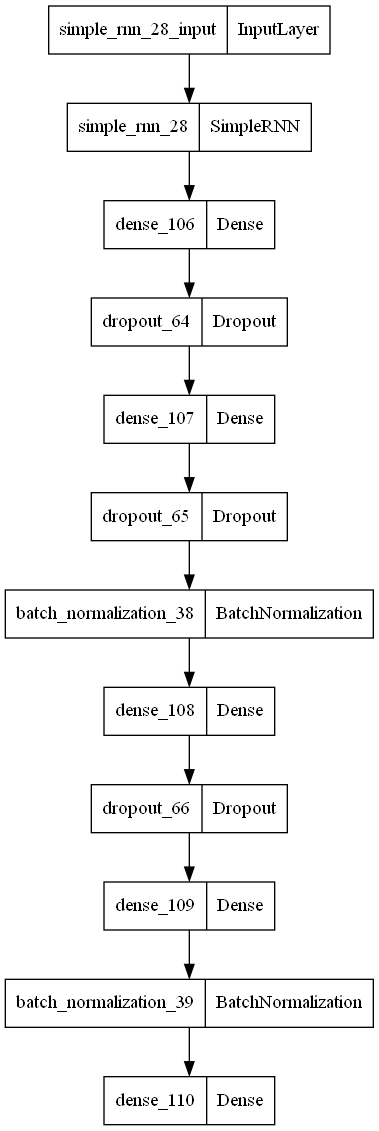

In [183]:
plot_model(model, to_file='plot.png', show_layer_names=True)


In [184]:
# Define Callbacks
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 patience=4,
                                                 verbose=1,
                                                 factor=0.4,
                                                 min_lr=0.0001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              min_delta=0.00001,
                                              patience=8,
                                              mode='auto',
                                              restore_best_weights=True)

MCP = tf.keras.callbacks.ModelCheckpoint('Best_points.h5',
                                         verbose=1,
                                         save_best_only=True,
                                         monitor='val_accuracy',
                                         mode='max')

# Train the model
history = model.fit(np.expand_dims(X_train, axis=2), y_train, validation_data=(X_val, y_val),epochs=100, batch_size=32, callbacks=[early_stop, lr_reduction, MCP])

Epoch 1/100
22/23 [===========================>..] - ETA: 0s - loss: 1.9002 - accuracy: 0.6065
Epoch 1: val_accuracy improved from -inf to 0.67039, saving model to Best_points.h5
23/23 [==============================] - 2s 33ms/step - loss: 1.9014 - accuracy: 0.6067 - val_loss: 1.7483 - val_accuracy: 0.6704 - lr: 0.0010
Epoch 2/100
22/23 [===========================>..] - ETA: 0s - loss: 1.6662 - accuracy: 0.7116
Epoch 2: val_accuracy did not improve from 0.67039
23/23 [==============================] - 0s 21ms/step - loss: 1.6661 - accuracy: 0.7121 - val_loss: 1.6939 - val_accuracy: 0.6145 - lr: 0.0010
Epoch 3/100
22/23 [===========================>..] - ETA: 0s - loss: 1.6458 - accuracy: 0.7145
Epoch 3: val_accuracy did not improve from 0.67039
23/23 [==============================] - 0s 20ms/step - loss: 1.6433 - accuracy: 0.7149 - val_loss: 1.6466 - val_accuracy: 0.6313 - lr: 0.0010
Epoch 4/100
22/23 [===========================>..] - ETA: 0s - loss: 1.6111 - accuracy: 0.7159
Epoch

### Visualizing Accuracy
Here we will visualize the accuracy of the model as it trains.

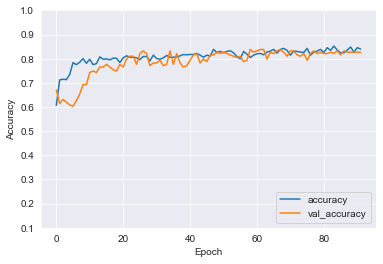

In [185]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')
plt.show()

Predicting on the test dataset. We need to make a copy because the model does not expect a passengerID but we need it for the submission.

In [186]:
testCopy_tf = test_df.copy()
testCopy_tf.drop('PassengerId', axis=1, inplace=True)
testCopy_tf.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,-0.496740,0,0,-0.497811,0,0,1,0,1,0,1,0
1,0.738774,1,0,-0.512660,0,0,1,1,0,0,0,1
2,-0.187862,0,0,-0.464532,0,1,0,0,1,0,1,0
3,0.507115,0,0,-0.482888,0,0,1,0,1,0,0,1
4,0.507115,1,1,-0.417971,0,0,1,1,0,0,0,1


In [187]:
# Predict the outputs for the test dataset
y_pred = model.predict(np.expand_dims(testCopy_tf, axis=2))
y_pred = np.round(y_pred).astype(int).flatten()

14/14 [==============================] - 0s 4ms/step


In [188]:
# Save the predictions to a CSV file
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_pred
})
submission.to_csv('submission.csv', index=False)

Test Accuracy was 78.7% according to the Kaggle competition, which is Top 10% according to the Leaderboards. 

In [189]:
# Loading the model with the best weights
model.load_weights('Best_points.h5')

# Saving the model as a savedModel
model.save('model', save_format='tf')

INFO:tensorflow:Assets written to: model\assets
